<a href="https://colab.research.google.com/github/tieukhoimai/binary-signal-recovery/blob/main/binary_signal_recovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/vrn/probability

/content/drive/MyDrive/vrn/probability


## Generate data

Let:

*  $\mathbf{X} \in \mathbb{R}^{m \times d}$ be a random matrix with i.i.d. entries drawn from $\mathcal{N}(0,1)$.
*  $\boldsymbol{\xi} \in \mathbb{R}^m$ be a noise vector with i.i.d. entries drawn from $\mathcal{N}(0,1)$, independent of $\mathbf{X}$.
*  $\Theta = \{0,1\}^d$ be the signal space.
*  $\boldsymbol{\theta} \in \Theta$ be a signal chosen uniformly at random, independent of $(\mathbf{X}, \boldsymbol{\xi})$.

The measurement vector $\mathbf{y} \in \mathbb{R}^m$ is generated as:

$$\mathbf{y} = \mathbf{X} \boldsymbol{\theta} + \boldsymbol{\xi}$$

In [ ]:
def generate_data(m, d):
  X = np.random.randn(m, d)  # Sensing matrix
  xi = np.random.randn(m)   # Noise
  theta = np.random.randint(2, size=d)  # Signal
  y = X @ theta + xi  # Measurements
  return X, y, theta

## Define the likelihood and energy functions

**1. Likelihood Function ($L$):**

- **Assumption:** The noise vector $\boldsymbol{\xi}$ follows a multivariate normal distribution with zero mean and identity covariance matrix, denoted as $\boldsymbol{\xi} \sim \mathcal{N}(0,I)$.
- **Measurement Model:** $\mathbf{y} = \mathbf{X} \boldsymbol{\theta} + \boldsymbol{\xi}$

Since $\boldsymbol{\xi}$ is a multivariate normal, its probability density function (pdf) is:


$$\mathcal{L}(\xi) = (2\pi)^{-m/2} \times exp\{-\frac{1}{2} \xi^T \xi\}$$


Now, we want to find the probability of observing $y$ given $X$ and $\theta$, which is equivalent to finding the probability of the noise ξ being equal to $\mathbf{y} - \mathbf{X} \boldsymbol{\theta}$:


$$\mathcal{L}(y | X, \theta) = p(\xi = y - X\theta)
                   = (2\pi)^{-m/2} \times exp\{-\frac{1}{2} (y - X\theta)^T (y - X\theta)\}$$


This is the likelihood function $L(X, y; \theta)$:

$$\mathcal{L}(X, y; \theta) = \frac{exp\{-\frac{1}{2} (y - X \theta)^T (y - X\theta)\}}{(2\pi)^{m/2}}$$

**2. Minimization Function ($H$):**

- To maximize this function, we can maximize the logarithm of this function. Take the logarithm, we have:
$$
\log\mathcal{L}(X, y ; \theta)=-\frac{1}{2}(y-X \theta)^{\top}(y-X \theta)-\dfrac{m}{2}\log(2 \pi),
$$

- We can equivalently cast the question in the form of a minimization problem. Indeed, the maximum likelihood estimate of $\theta$ is given by the value $\hat{\theta} \in \Theta$ that minimizes the function
$$
\mathcal{H}(X, y ; \theta)=-\left [-(y-X^\theta)^{\top}(y-X ^\theta)\right ]=(y-X^\theta)^{\top}(y-X ^\theta),
$$
given the observations $(X, y)$, and $\dfrac{1}{2}, \dfrac{m}{2}\log(2 \pi)$ are constants, so we can vanish them.

- To simplify the optimization problem, we define a new function $H(X, y; \theta)$ as the exponent:
$$H(X, y; \theta) = (y - X\theta)^T (y - X\theta)$$

By minimizing $H(X, y; \theta)$, we essentially maximize the likelihood function $L(X, y; \theta)$ and find the maximum likelihood estimate of $\theta$.

**In summary:**

- **Maximize:** $$\mathcal{L}(\xi) = (2\pi)^{-m/2} \times exp\{-\frac{1}{2} \xi^T \xi\}$$
- **Minimize:** $$H(X, y; \theta) = (y - X\theta)^T (y - X\theta)$$


In [ ]:
def H(X, y, theta):
  return (y - X @ theta).T @ (y - X @ theta)

## Metropolis-Hastings algorithm

1. Set $\boldsymbol{\theta}_0 = \bar{\boldsymbol{\theta}}$.
2. For $t = 1, 2, \ldots, N - 1$:
   1. Pick $i$ uniformly at random in $\{1, 2, \ldots, d\}$.
   2. Let the proposed state be $\boldsymbol{\theta}^* \in \Theta$, with entries $\boldsymbol{\theta}^*(j) = $
      \begin{cases}
          \boldsymbol{\theta}^{t-1}(j) & \text{if } j \neq i \\
          1 - \boldsymbol{\theta}^{t-1}(j) & \text{if } j = i
      \end{cases}
    
    for $ j = 1, 2, \ldots, d. $
   3. Set
      $\boldsymbol{\theta}^t = $
      
      \begin{cases}
          \boldsymbol{\theta}^* & \text{with probability } \min\left\{1, \frac{\exp\{-\beta H(\mathbf{X}, \mathbf{y}; \boldsymbol{\theta}^*)\}}{\exp\{-\beta H(\mathbf{X}, \mathbf{y}; \boldsymbol{\theta}^{t-1})\}}\right\} \\
          \boldsymbol{\theta}^{t-1} & \text{with probability } 1 - \min\left\{1, \frac{\exp\{-\beta H(\mathbf{X}, \mathbf{y}; \boldsymbol{\theta}^*)\}}{\exp\{-\beta H(\mathbf{X}, \mathbf{y}; \boldsymbol{\theta}^{t-1})\}}\right\}
      \end{cases}

In [ ]:
def metropolis_hastings(X, y, beta, M, initial_theta):
  d = len(initial_theta)
  theta = initial_theta.copy()

  for _ in range(M):
    i = np.random.randint(d)
    theta_star = theta.copy()
    theta_star[i] = 1 - theta_star[i]

    acceptance_prob = min(1, np.exp(-beta * (H(X, y, theta_star) - H(X, y, theta))))

    if np.random.rand() < acceptance_prob:
      theta = theta_star

  return theta

## Experimental

In [ ]:
def experiment(d=10, m_max=15, N=100, M=100, beta=1.0):
  start_time = time.time()
  ms = range(1, m_max + 1)
  MSEs = []

  for m in ms:
      mse = 0
      for _ in range(N):
          X, y, theta_true = generate_data(m, d)
          initial_theta = np.random.randint(2, size=d)
          theta_hat = metropolis_hastings(X, y, beta, M, initial_theta)
          mse += ((theta_hat - theta_true).T @ (theta_hat - theta_true)) / M
      MSEs.append(mse)

  end_time = time.time()
  avg_time = (end_time - start_time)

  return ms, MSEs, avg_time, N, M, beta

### Experiment with different values of $\beta$

In [ ]:
# Create an empty list to store the results
results = []

# Loop through the beta values
beta_values = np.linspace(0.1, 2.0, 5)

for beta_i in beta_values:
  ms, MSEs, avg_time, N, M, beta = experiment(d=10, m_max=15, N=1000, M=1000, beta=beta_i)

  # Store the results in the list
  results.append({
        'M': M,
        'N': N,
        'beta': beta,
        'm': list(ms),
        'MSE': MSEs,
        'Time': avg_time
    })

# Create a pandas DataFrame from the results list
df = pd.DataFrame(results)

In [ ]:
df

,M,N,beta,m,MSE,Time
0,1000,1000,0.100,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4.883999999999949, 4.727999999999953, 4.45599...",333.190022
1,1000,1000,0.575,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4.666999999999954, 4.306999999999962, 3.97299...",322.509038
2,1000,1000,1.050,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4.489999999999955, 4.208999999999962, 3.85699...",324.471149
3,1000,1000,1.525,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4.633999999999948, 4.13599999999996, 3.660999...",323.133945
4,1000,1000,2.000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4.5249999999999595, 4.12299999999996, 3.64599...",321.659560


In [ ]:
df.to_csv('beta_exp.csv',index=False)

In [ ]:
df = pd.read_csv('beta_exp.csv')

In [ ]:
def convert_str_to_arr(str_value):
  return [float(x.strip()) for x in str_value.strip('[]').split(',')]

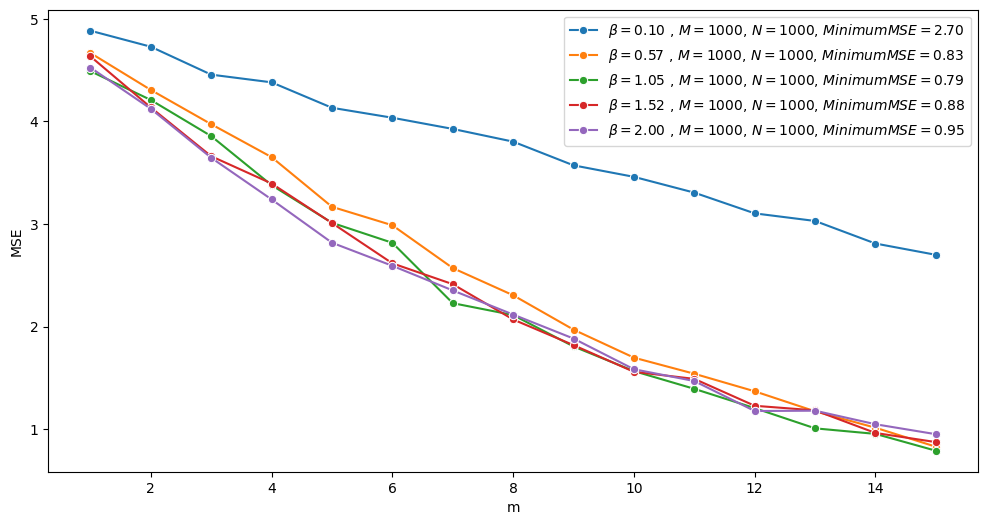

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

for i in range(0,len(df)):
  m = convert_str_to_arr(df['m'][i])
  mse = convert_str_to_arr(df['MSE'][i])
  label = r'$\beta = {0:.2f}$ , $M = {1:.0f}$, $N = {2:.0f}$, $Minimum MSE = {3:.2f}$'.format(df['beta'][i], df['M'][i], df['N'][i], min(mse))
  sns.lineplot(x=m, y=mse, marker='o',label=label)

ax.set_xlabel('m')
ax.set_ylabel('MSE')
plt.show()

The plot shows the mean squared error (MSE) of the recovered signal as a function of the number of measurements (m) for different values of the parameter $\beta$ in the Metropolis-Hastings algorithm. We can make the following observations:

* **General trend:** As expected, the MSE decreases as the number of measurements increases. This is because more measurements provide more information about the unknown signal, leading to better recovery.
* **Influence of $\beta$ :** The parameter  $\beta$ controls the sharpness of the stationary distribution of the Markov chain. A higher  $\beta$ concentrates the distribution around the maximum likelihood estimate, leading to lower MSE for sufficiently large m. However, higher β values might also make the algorithm slower to converge.
* **Optimal  $\beta$:**  There seems to be an optimal range for β where the MSE is minimized for a given m. For example,  $\beta = 1.05$ seems to perform well for most m values in the plot. However, finding the absolute optimal β would require a more thorough analysis.
* **Reliability:** While the MSE generally decreases with $m$, there might not be a single "minimum value" of $m/d$ that guarantees reliable recovery for all cases. The required $m/d$ for reliable recovery can depend on various factors like the desired accuracy, the chosen  $\beta$, and the inherent noise level in the data.

To determine a suitable $m/d$ for "reliable" recovery, we need to define an acceptable MSE threshold. For instance, if we consider an MSE of 1.0 to be sufficiently low, then $m/d ≈ 1.0$ might be acceptable for some  $\beta$ values. However, if we require even lower MSE, then a higher $m/d$ would be necessary.

It's important to note that this analysis is based on a specific set of parameters $(d = 10, M = 1000, N = 1000)$. Changing these parameters might lead to different results.

In conclusion, the plot highlights the trade-off between the number of measurements, the parameter  $\beta$, and the accuracy of the recovered signal. While a higher $m$ and an appropriate  $\beta$ can improve the recovery, defining a universal "minimum $m/d$" for reliable recovery depends on the specific application requirements and acceptable error tolerance.


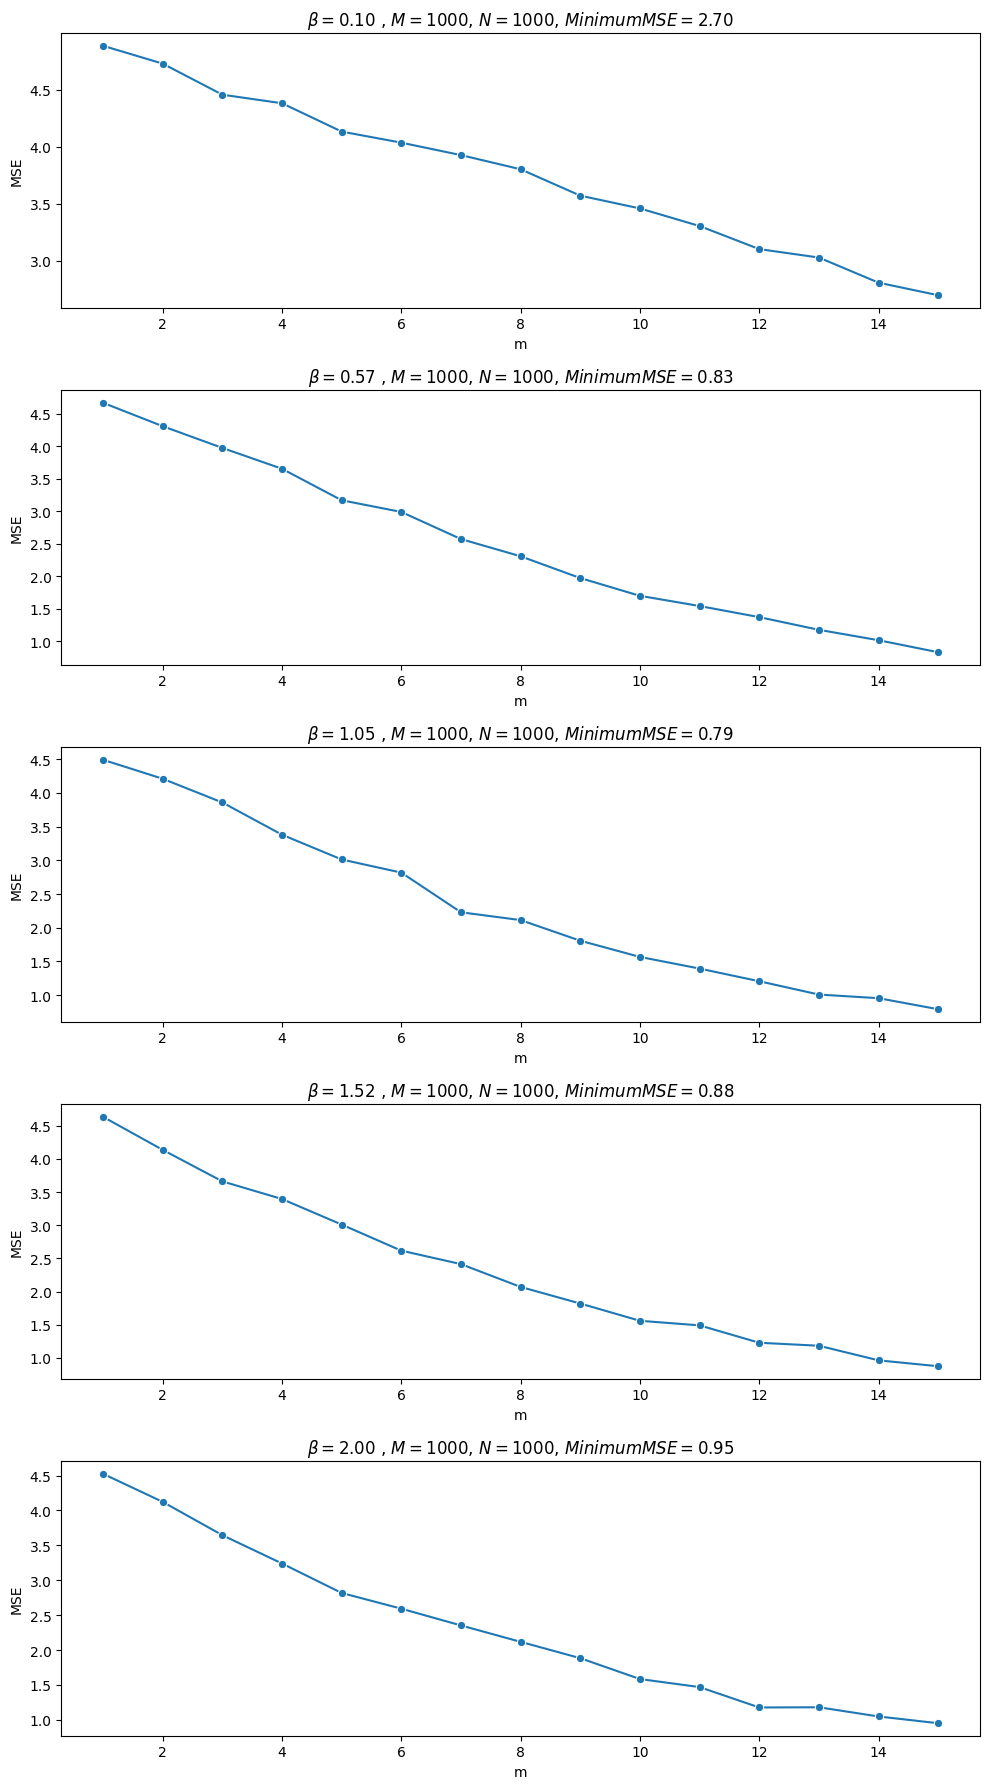

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 18))

for i in range(len(df)):
    m = convert_str_to_arr(df['m'][i])
    mse = convert_str_to_arr(df['MSE'][i])
    title = r'$\beta = {0:.2f}$ , $M = {1:.0f}$, $N = {2:.0f}$, $Minimum MSE = {3:.2f}$'.format(df['beta'][i], df['M'][i], df['N'][i], min(mse))

    # Plot on each subplot
    sns.lineplot(x=m, y=mse, marker='o', ax=axes[i])
    axes[i].set_title(title)
    axes[i].set_xlabel('m')
    axes[i].set_ylabel('MSE')

# Adjust layout and display
plt.tight_layout()
plt.show()

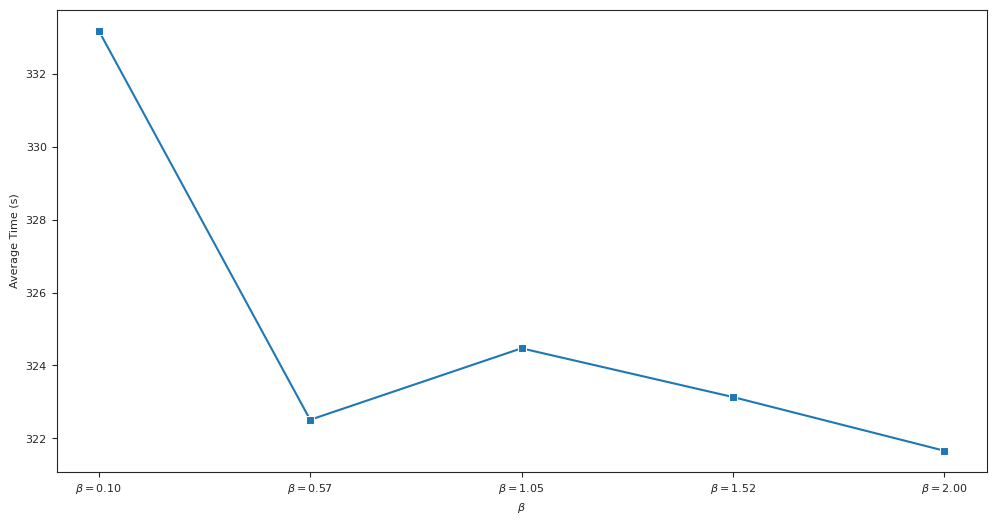

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.lineplot(data=df, x='beta', y='Time', marker='s')
ax.set_xticks(beta_values)
ax.set_xticklabels([r'$\beta = {:.2f}$'.format(beta) for beta in beta_values])
ax.set_xlabel(r'$\beta$')
ax.set_ylabel("Average Time (s)")
ax.grid(False)

## Experiment with different values of $M$

In [ ]:
# Create an empty list to store the results
m_results = []

# Loop through the beta values
M_values = np.linspace(1000, 10000, 5, dtype=int)

for M_i in M_values:
  ms, MSEs, avg_time, N, M, beta = experiment(d=10, m_max=15, N=1000, M=M_i, beta=1.0)

  # Store the results in the list
  m_results.append({
        'M': M,
        'N': N,
        'beta': beta,
        'm': list(ms),
        'MSE': MSEs,
        'Time': avg_time
    })

# Create a pandas DataFrame from the results list
df_m = pd.DataFrame(m_results)

In [ ]:
df_m

,M,N,beta,m,MSE,Time
0,1000,1000,1.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4.578999999999954, 4.180999999999963, 3.86099...",426.575558
1,3250,1000,1.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.414461538461537, 1.2969230769230722, 1.1624...",1381.337108
2,5500,1000,1.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.8281818181818139, 0.7836363636363586, 0.694...",2338.323926
3,7750,1000,1.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.5943225806451659, 0.5424516129032306, 0.491...",3268.711053
4,10000,1000,1.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.46540000000000026, 0.42350000000000065, 0.3...",4431.456508


In [ ]:
df_m.to_csv('/content/drive/MyDrive/vrn/probability/m_exp.csv',index=False)

In [ ]:
df_m = pd.read_csv('/content/drive/MyDrive/vrn/probability/m_exp.csv')

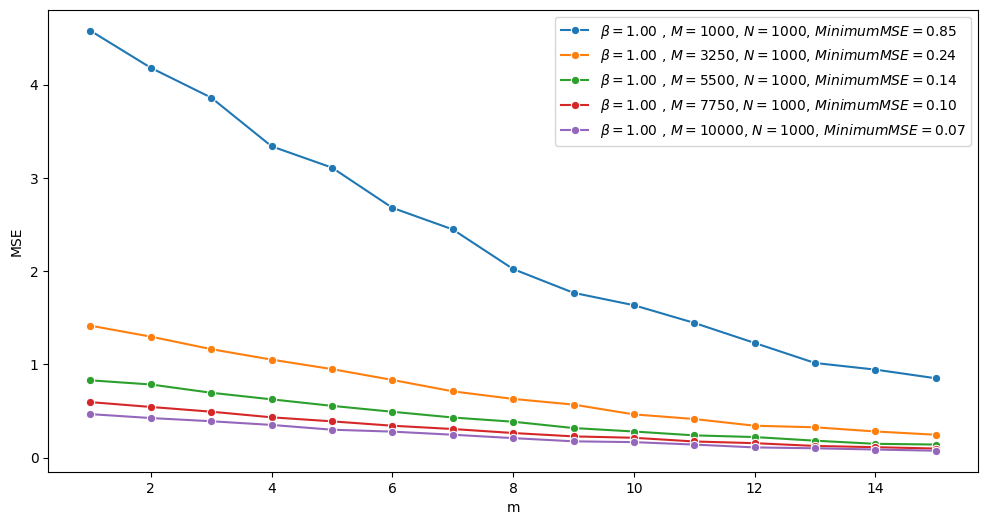

In [ ]:
ms = range(1, 16)

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(0,len(df)):
  label = r'$\beta = {0:.2f}$ , $M = {1:.0f}$, $N = {2:.0f}$, $Minimum MSE = {3:.2f}$'.format(df_m['beta'][i], df_m['M'][i], df_m['N'][i], min(df_m['MSE'][i]))
  sns.lineplot(x=df_m['m'][i], y=df_m['MSE'][i], marker='o',label=label)

ax.set_xlabel('m')
ax.set_ylabel('MSE')
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.show()

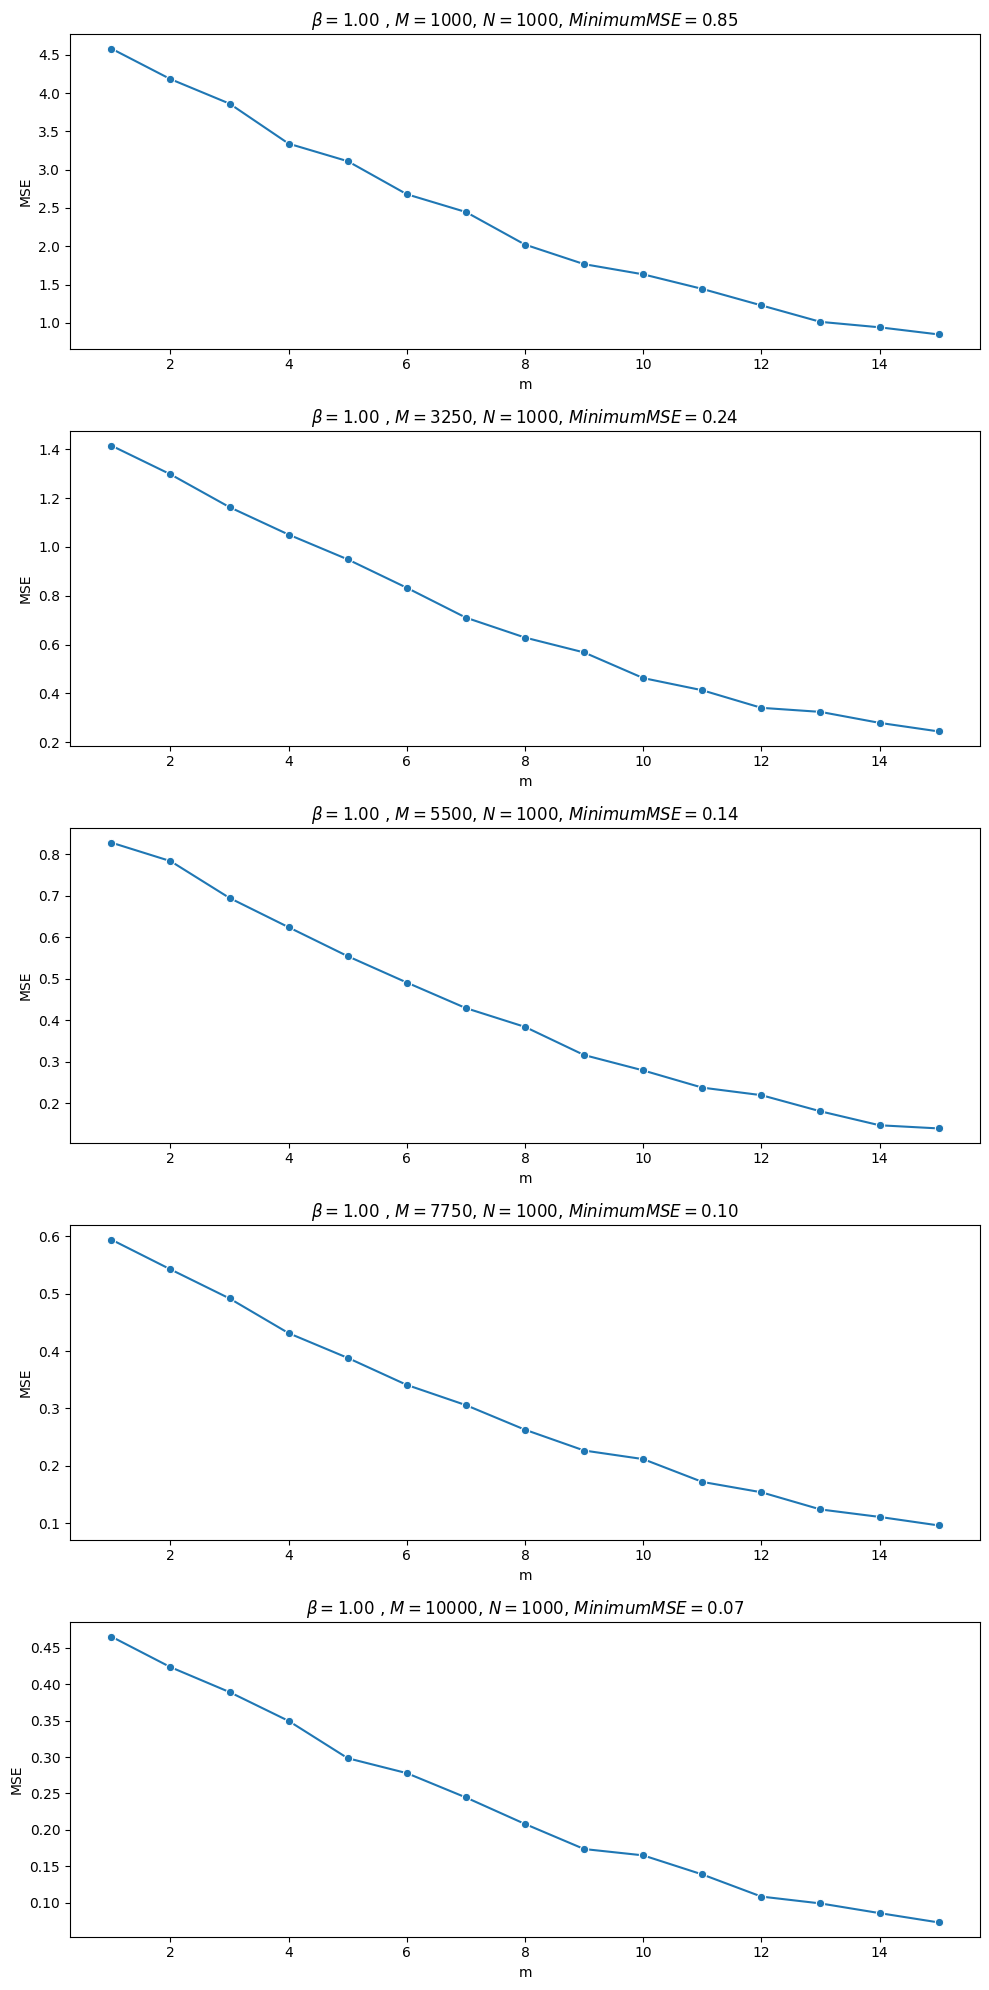

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))

for i in range(len(df_m)):
    m = convert_str_to_arr(df_m['m'][i])
    mse = convert_str_to_arr(df_m['MSE'][i])
    title = r'$\beta = {0:.2f}$ , $M = {1:.0f}$, $N = {2:.0f}$, $Minimum MSE = {3:.2f}$'.format(df_m['beta'][i], df_m['M'][i], df_m['N'][i], min(mse))

    # Plot on each subplot
    sns.lineplot(x=m, y=mse, marker='o', ax=axes[i])
    axes[i].set_title(title)
    axes[i].set_xlabel('m')
    axes[i].set_ylabel('MSE')

# Adjust layout and display
plt.tight_layout()
plt.show()

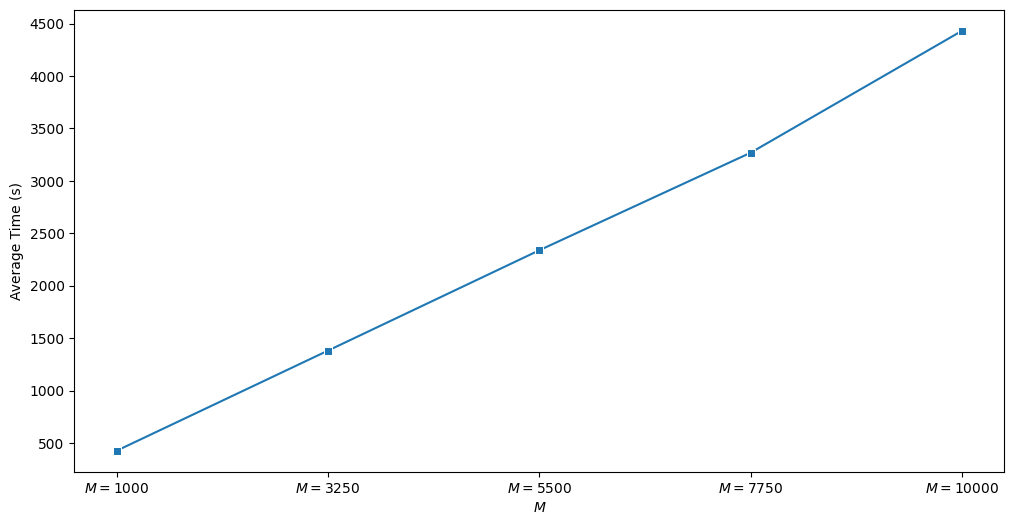

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.lineplot(data=df_m, x='M', y='Time', marker='s')
ax.set_xticks(M_values)
ax.set_xticklabels([r'$M = {}$'.format(str(M)) for M in M_values])
ax.set_xlabel(r'$M$')
ax.set_ylabel("Average Time (s)")
ax.grid(False)